In [1]:
import yaml
import cv2
import os
from glob import glob

import matplotlib.pyplot as plt
import torchvision.transforms as transforms

import imgaug.augmenters as iaa
from data import rand_perlin_2d_np
from utils import torch_seed
import torch
from torch.utils.data import Dataset

import numpy as np

from typing import Union, List, Tuple

from einops import rearrange

In [2]:
cfg = yaml.load(open('./configs/capsule.yaml','r'), Loader=yaml.FullLoader)

In [3]:
class MemSegDataset(Dataset):
    def __init__(
        self, datadir: str, target: str, train: bool, to_memory: bool = False,
        resize: Tuple[int, int] = (224,224),
        texture_source_dir: str = None, structure_grid_size: str = 8,
        transparency_range: List[float] = [0.15, 1.],
        perlin_scale: int = 6, min_perlin_scale: int = 0, perlin_noise_threshold: float = 0.5,
    ):
        # mode
        self.train = train 
        self.to_memory = to_memory

        # load image file list
        self.datadir = datadir
        self.target = target
        self.file_list = glob(os.path.join(self.datadir, self.target, 'train/*/*' if train else 'test/*/*'))
        
        # load texture image file list
        if texture_source_dir:
            self.texture_source_file_list = glob(os.path.join(texture_source_dir,'*/*'))
            
        # synthetic anomaly
        if train:
            self.transparency_range = transparency_range
            self.perlin_scale = perlin_scale
            self.min_perlin_scale = min_perlin_scale
            self.perlin_noise_threshold = perlin_noise_threshold
            self.structure_grid_size = structure_grid_size
        
        # transform ndarray into tensor
        self.resize = resize
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(
                mean = (0.485, 0.456, 0.406),
                std  = (0.229, 0.224, 0.225)
            )
        ])

        # sythetic anomaly switch
        self.anomaly_switch = False
        
    def __getitem__(self, idx):
        
        file_path = self.file_list[idx]
        
        # image
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, dsize=(self.resize[1], self.resize[0]))
        
        # target
        target = 0 if 'good' in self.file_list[idx] else 1
        
        # mask
        if 'good' in file_path:
            mask = np.zeros(self.resize, dtype=np.float32)
        else:
            mask = cv2.imread(
                file_path.replace('test','ground_truth').replace('.png','_mask.png'), 
                cv2.IMREAD_GRAYSCALE
            )
            mask = cv2.resize(mask, dsize=self.resize).astype(np.bool).astype(np.int)

        ## anomaly source
        if not self.to_memory and self.train:
            if self.anomaly_switch:
                img, mask = self.generate_anomaly(img=img)
                target = 1
                self.anomaly_switch = False
            else:        
                self.anomaly_switch = True
            
        # convert ndarray into tensor
        img = self.transform(img)
        mask = torch.Tensor(mask).to(torch.int64)
        
        return img, mask, target
        
        
    def rand_augment(self):
        augmenters = [
            iaa.GammaContrast((0.5,2.0),per_channel=True),
            iaa.MultiplyAndAddToBrightness(mul=(0.8,1.2),add=(-30,30)),
            iaa.pillike.EnhanceSharpness(),
            iaa.AddToHueAndSaturation((-50,50),per_channel=True),
            iaa.Solarize(0.5, threshold=(32,128)),
            iaa.Posterize(),
            iaa.Invert(),
            iaa.pillike.Autocontrast(),
            iaa.pillike.Equalize(),
            iaa.Affine(rotate=(-45, 45))
        ]

        aug_idx = np.random.choice(np.arange(len(augmenters)), 3, replace=False)
        aug = iaa.Sequential([
            augmenters[aug_idx[0]],
            augmenters[aug_idx[1]],
            augmenters[aug_idx[2]]
        ])
        
        return aug
        
    def generate_anomaly(self, img: np.ndarray) -> List[np.ndarray]:
        '''
        step 1. generate mask
            - target foreground mask
            - perlin noise mask
            
        step 2. generate texture or structure anomaly
            - texture: load DTD
            - structure: we first perform random adjustment of mirror symmetry, rotation, brightness, saturation, 
            and hue on the input image  𝐼 . Then the preliminary processed image is uniformly divided into a 4×8 grid 
            and randomly arranged to obtain the disordered image  𝐼 
            
        step 3. blending image and anomaly source
        '''
        
        # step 1. generate mask
        
        ## target foreground mask
        target_foreground_mask = self.generate_target_foreground_mask(img=img)
        
        ## perlin noise mask
        perlin_noise_mask = self.generate_perlin_noise_mask()
        
        ## mask
        mask = perlin_noise_mask * target_foreground_mask
        mask_expanded = np.expand_dims(mask, axis=2)
        
        # step 2. generate texture or structure anomaly
        
        ## anomaly source
        anomaly_source_img = self.anomaly_source(img=img)
        
        ## mask anomaly parts
        factor = np.random.uniform(*self.transparency_range, size=1)[0]
        anomaly_source_img = factor * (mask_expanded * anomaly_source_img) + (1 - factor) * (mask_expanded * img)
        
        # step 3. blending image and anomaly source
        anomaly_source_img = ((- mask_expanded + 1) * img) + anomaly_source_img
        
        return (anomaly_source_img.astype(np.uint8), mask)
    
    def generate_target_foreground_mask(self, img: np.ndarray) -> np.ndarray:
        # convert RGB into GRAY scale
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        # generate binary mask of gray scale image
        _, target_background_mask = cv2.threshold(img_gray, 100, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        target_background_mask = target_background_mask.astype(np.bool).astype(np.int)

        # invert mask for foreground mask
        target_foreground_mask = -(target_background_mask - 1)
        
        return target_foreground_mask
    
    def generate_perlin_noise_mask(self) -> np.ndarray:
        # define perlin noise scale
        perlin_scalex = 2 ** (torch.randint(self.min_perlin_scale, self.perlin_scale, (1,)).numpy()[0])
        perlin_scaley = 2 ** (torch.randint(self.min_perlin_scale, self.perlin_scale, (1,)).numpy()[0])

        # generate perlin noise
        perlin_noise = rand_perlin_2d_np((self.resize[0], self.resize[1]), (perlin_scalex, perlin_scaley))
        
        # apply affine transform
        rot = iaa.Affine(rotate=(-90, 90))
        perlin_noise = rot(image=perlin_noise)
        
        # make a mask by applying threshold
        mask_noise = np.where(
            perlin_noise > self.perlin_noise_threshold, 
            np.ones_like(perlin_noise), 
            np.zeros_like(perlin_noise)
        )
        
        return mask_noise
    
    def anomaly_source(self, img: np.ndarray) -> np.ndarray:
        p = np.random.uniform()
        if p < 0.5:
            # TODO: None texture_source_file_list
            anomaly_source_img = self._texture_source()
        else:
            anomaly_source_img = self._structure_source(img=img)
            
        return anomaly_source_img
        
    def _texture_source(self) -> np.ndarray:
        idx = np.random.choice(len(self.texture_source_file_list))
        texture_source_img = cv2.imread(self.texture_source_file_list[idx])
        texture_source_img = cv2.cvtColor(texture_source_img, cv2.COLOR_BGR2RGB)
        texture_source_img = cv2.resize(texture_source_img, dsize=self.resize).astype(np.float32)
        
        return texture_source_img
        
    def _structure_source(self, img: np.ndarray) -> np.ndarray:
        structure_source_img = self.rand_augment()(image=img)
        
        assert self.resize[0] % self.structure_grid_size == 0, 'structure should be devided by grid size accurately'
        grid_w = self.resize[0] // self.structure_grid_size
        grid_h = self.resize[1] // self.structure_grid_size
        
        structure_source_img = rearrange(
            tensor  = structure_source_img, 
            pattern = '(h gh) (w gw) c -> (h w) gw gh c',
            gw      = grid_w, 
            gh      = grid_h
        )
        disordered_idx = np.arange(structure_source_img.shape[0])
        np.random.shuffle(disordered_idx)

        structure_source_img = rearrange(
            tensor  = structure_source_img[disordered_idx], 
            pattern = '(h w) gw gh c -> (h gh) (w gw) c',
            h       = self.structure_grid_size,
            w       = self.structure_grid_size
        ).astype(np.float32)
        
        return structure_source_img
        
    def __len__(self):
        return len(self.file_list)

# Example

In [4]:
trainset = MemSegDataset(
    datadir                = cfg['DATASET']['datadir'],
    target                 = cfg['DATASET']['target'], 
    train                  = True,
    resize                 = cfg['DATASET']['resize'],
    texture_source_dir     = cfg['DATASET']['texture_source_dir'],
    structure_grid_size    = cfg['DATASET']['structure_grid_size'],
    transparency_range     = cfg['DATASET']['transparency_range'],
    perlin_scale           = cfg['DATASET']['perlin_scale'], 
    min_perlin_scale       = cfg['DATASET']['min_perlin_scale'], 
    perlin_noise_threshold = cfg['DATASET']['perlin_noise_threshold']
)

In [5]:
def minmax_scaling(img):
    return (((img - img.min()) / (img.max() - img.min())) * 255).to(torch.uint8)

Text(0.5, 1.0, 'mask')

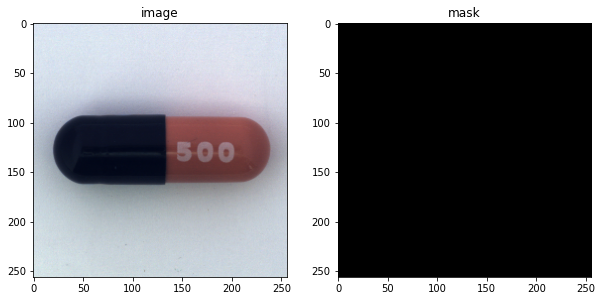

In [6]:
img, mask, target = trainset[0]

fig, ax = plt.subplots(1,2,figsize=(10,15))
ax[0].imshow(minmax_scaling(img.permute(1,2,0)))
ax[0].set_title('image')
ax[1].imshow(minmax_scaling(mask), cmap='gray')
ax[1].set_title('mask')

# Loader Image

In [7]:
os.listdir(cfg['DATASET']['datadir'])

['carpet',
 'pill',
 'toothbrush',
 'grid',
 'license.txt',
 'wood',
 'capsule',
 'cable',
 'zipper',
 'readme.txt',
 'bottle',
 'tile',
 'screw',
 'metal_nut',
 'transistor',
 'leather',
 'hazelnut']

In [8]:
train_file_list = glob(os.path.join(cfg['DATASET']['datadir'], cfg['DATASET']['target'], 'train/*/*'))

In [9]:
img = cv2.imread(train_file_list[4])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, dsize=(cfg['DATASET']['resize'][1], cfg['DATASET']['resize'][0]))
img.shape

(256, 256, 3)

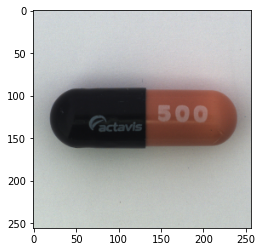

In [10]:
plt.imshow(img)

# Generate Synthetic Anomaly Process
1. generate mask 
    - target foreground mask
    - perlin noise mask
2. generate texture or structure anomaly
    - texture: load DTD
    - structure: we first perform random adjustment of mirror symmetry, rotation, brightness, saturation, and hue on the input image $I$. Then the preliminary processed image is uniformly divided into a 4×8 grid and randomly arranged to obtain the disordered image $I$
3. blending

![image](https://user-images.githubusercontent.com/37654013/198633289-cb14e5b4-1f55-4802-a880-720f8209431e.png)

# Step 1. Generate Mask

## target foreground

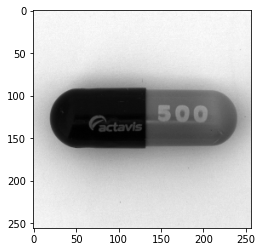

In [11]:
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(img_gray, cmap='gray')

In [12]:
_, mask_target_background = cv2.threshold(img_gray, 100, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
mask_target_background = mask_target_background.astype(np.bool).astype(np.int)
mask_target_foreground = -(mask_target_background - 1)

/tmp/ipykernel_4102447/1913420044.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask_target_background = mask_target_background.astype(np.bool).astype(np.int)
/tmp/ipykernel_4102447/1913420044.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-no

Text(0.5, 1.0, 'Foreground')

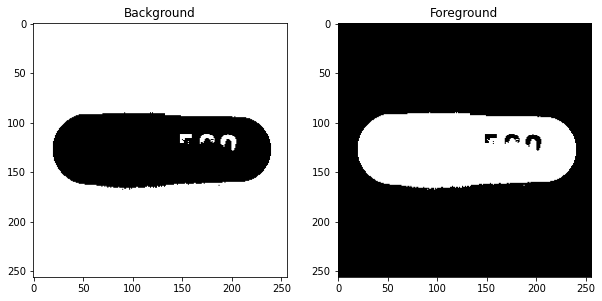

In [13]:
fig, ax = plt.subplots(1,2, figsize=(10,15))
ax[0].imshow(mask_target_background, cmap='gray')
ax[0].set_title('Background')
ax[1].imshow(mask_target_foreground, cmap='gray')
ax[1].set_title('Foreground')

## Perlin noise

In [14]:
perlin_scale = 6
min_perlin_scale = 0

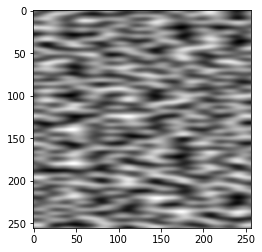

In [15]:
torch_seed(10)

perlin_scalex = 2 ** (torch.randint(min_perlin_scale, perlin_scale, (1,)).numpy()[0])
perlin_scaley = 2 ** (torch.randint(min_perlin_scale, perlin_scale, (1,)).numpy()[0])

perlin_noise = rand_perlin_2d_np(cfg['DATASET']['resize'], (perlin_scalex, perlin_scaley))

plt.imshow(perlin_noise, cmap='gray')

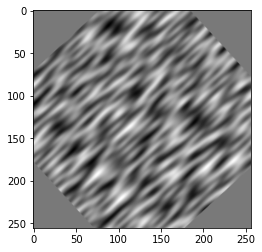

In [16]:
rot = iaa.Affine(rotate=(-90, 90))
perlin_noise = rot(image=perlin_noise)

plt.imshow(perlin_noise, cmap='gray')

In [17]:
print('max: ',perlin_noise.max())
print('min: ',perlin_noise.min())

max:  0.8909490778146016
min:  -0.8150710641347798


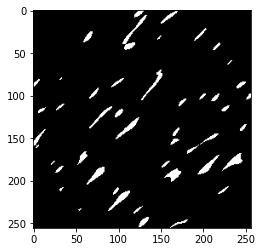

In [18]:
threshold = 0.5
mask_noise = np.where(perlin_noise > threshold, np.ones_like(perlin_noise), np.zeros_like(perlin_noise))

plt.imshow(mask_noise, cmap='gray')

## generate mask

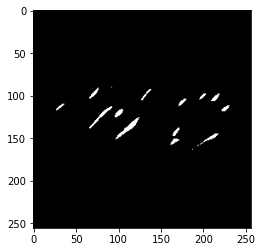

In [19]:
mask = mask_noise * mask_target_foreground
mask = np.expand_dims(mask, axis=2)
plt.imshow(mask, cmap='gray')

# Step 2: Generate Texture or Structure Anomaly

## Texture

- **texture**: load DTD

In [20]:
texture_source_file_list = glob(os.path.join(cfg['DATASET']['texture_source_dir'],'*/*'))

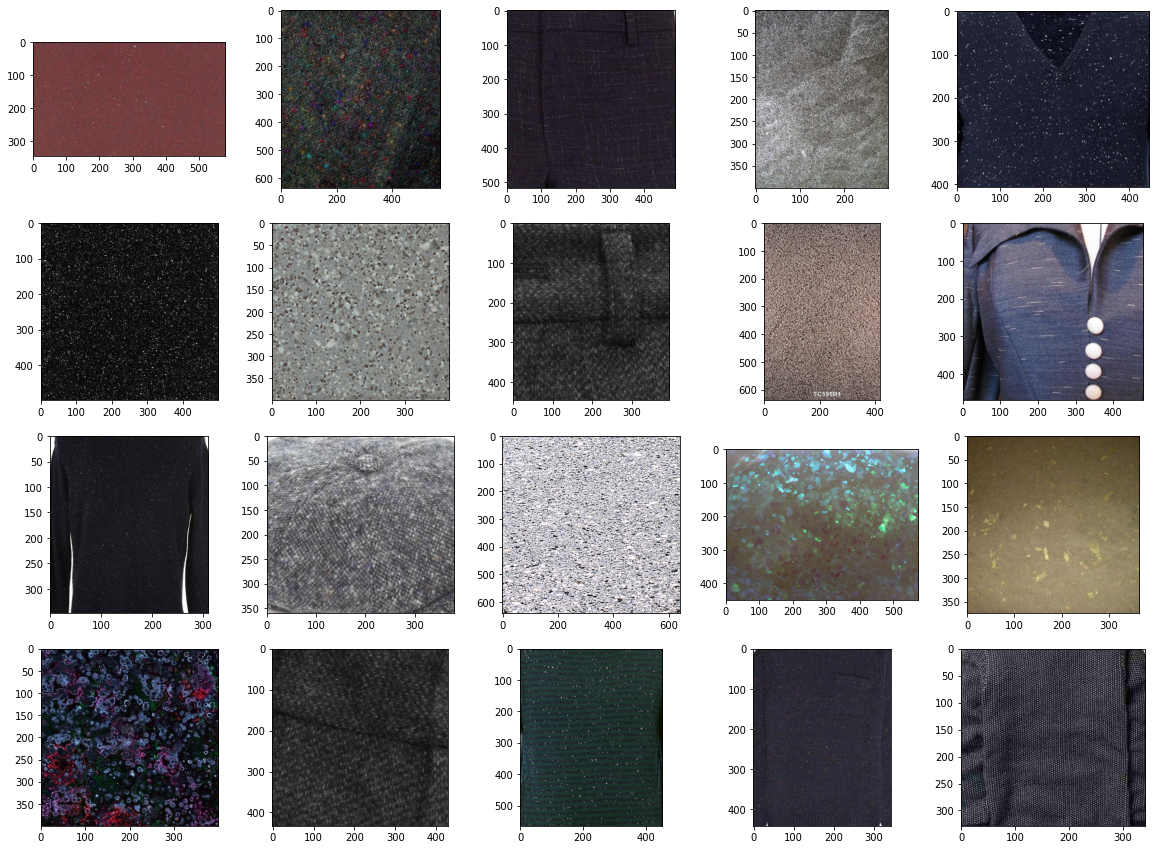

In [21]:
fig, ax = plt.subplots(4,5, figsize=(20,15))

for i in range(4*5):
    texture_source_img = cv2.imread(texture_source_file_list[i])
    texture_source_img = cv2.cvtColor(texture_source_img, cv2.COLOR_BGR2RGB)
    ax[i//5, i%5].imshow(texture_source_img)

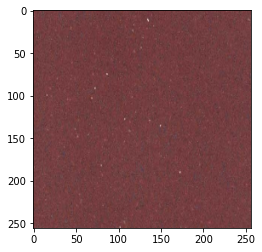

In [22]:
texture_source_img = cv2.imread(texture_source_file_list[0])
texture_source_img = cv2.cvtColor(texture_source_img, cv2.COLOR_BGR2RGB)
texture_source_img = cv2.resize(
    texture_source_img, 
    dsize=(cfg['DATASET']['resize'][1], cfg['DATASET']['resize'][0])
).astype(np.float32)
plt.imshow(texture_source_img.astype(np.uint8))

## Structure

**structure**: we first perform random adjustment of mirror symmetry, rotation, brightness, saturation, and hue on the input image $I$. Then the preliminary processed image is uniformly divided into a 4×8 grid and randomly arranged to obtain the disordered image $I$

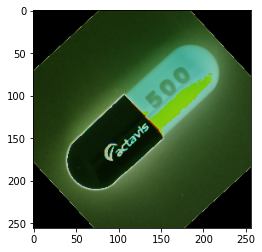

In [37]:
# https://github.com/VitjanZ/DRAEM/blob/main/data_loader.py

augmenters = [
    iaa.GammaContrast((0.5,2.0),per_channel=True),
    iaa.MultiplyAndAddToBrightness(mul=(0.8,1.2),add=(-30,30)),
    iaa.pillike.EnhanceSharpness(),
    iaa.AddToHueAndSaturation((-50,50),per_channel=True),
    iaa.Solarize(0.5, threshold=(32,128)),
    iaa.Posterize(),
    iaa.Invert(),
    iaa.pillike.Autocontrast(),
    iaa.pillike.Equalize(),
    iaa.Affine(rotate=(-45, 45))
]

aug_ind = np.random.choice(np.arange(len(augmenters)), 3, replace=False)
aug = iaa.Sequential([
    augmenters[aug_ind[0]],
    augmenters[aug_ind[1]],
    augmenters[aug_ind[2]]
])

structure_source_img = aug(image=img)
plt.imshow(structure_source_img)

In [24]:
assert cfg['DATASET']['resize'][0] % cfg['DATASET']['structure_grid_size'] == 0,  \
        'structure should be devided by grid size accurately'
grid_w = cfg['DATASET']['resize'][1] // cfg['DATASET']['structure_grid_size']
grid_h = cfg['DATASET']['resize'][0] // cfg['DATASET']['structure_grid_size']

In [25]:
structure_source_img = rearrange(
    tensor  = structure_source_img, 
    pattern = '(h gh) (w gw) c -> (h w) gw gh c',
    gw      = grid_w, 
    gh      = grid_h
)
disordered_idx = np.arange(structure_source_img.shape[0])
np.random.shuffle(disordered_idx)

structure_source_img = rearrange(
    tensor  = structure_source_img[disordered_idx], 
    pattern = '(h w) gw gh c -> (h gh) (w gw) c',
    h       = cfg['DATASET']['structure_grid_size'],
    w       = cfg['DATASET']['structure_grid_size']
).astype(np.float32)

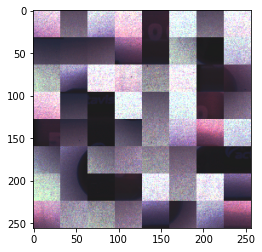

In [26]:
plt.imshow(structure_source_img.astype(np.uint8))

## Result

$$I'_n = \delta(M ⊙ I_n) + (1-\delta)(M ⊙ I)$$

- $M$: mask
- $I$: image
- $\delta$: transparency factor
- $I_n$: anomaly source

In [27]:
factor = np.random.uniform(
    cfg['DATASET']['transparency_range'][0], 
    cfg['DATASET']['transparency_range'][1], 
    size=1
)[0]

In [28]:
print('factor: ',factor)

factor:  0.9232131900985712


In [29]:
texture_source_img = factor * (mask * texture_source_img) + (1 - factor) * (mask * img)

In [30]:
structure_source_img = factor * (mask * structure_source_img) + (1 - factor) * (mask * img)

Text(0.5, 1.0, 'structure')

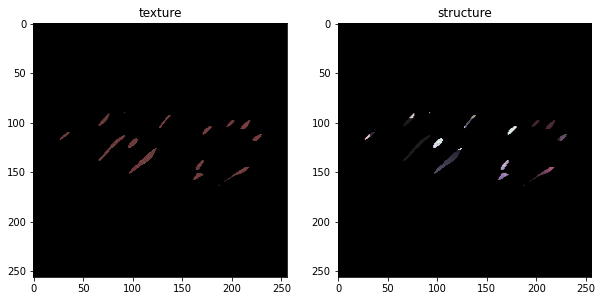

In [31]:
fig, ax = plt.subplots(1,2, figsize=(10,15))
ax[0].imshow(texture_source_img.astype(np.uint8))
ax[0].set_title('texture')
ax[1].imshow(structure_source_img.astype(np.uint8))
ax[1].set_title('structure')

# Step 3. Blending image and anomaly source

$$I_A = \bar{M} ⊙ I + I'_n$$

- $\bar{M}$: inverted mask

In [32]:
texture_anomaly = ((- mask + 1) * img) + texture_source_img
structure_anomaly = ((- mask + 1) * img) + structure_source_img

Text(0.5, 1.0, 'structure anomaly')

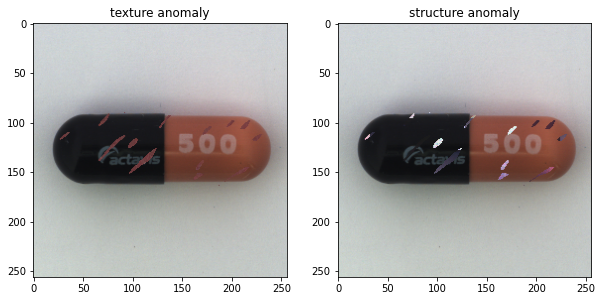

In [33]:
fig, ax = plt.subplots(1,2, figsize=(10,15))
ax[0].imshow(texture_anomaly.astype(np.uint8))
ax[0].set_title('texture anomaly')
ax[1].imshow(structure_anomaly.astype(np.uint8))
ax[1].set_title('structure anomaly')